In [1]:
import pymc3 as pm

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
#import pyjags
import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
n_theta = 10000

# generate 10,000 values from Beta(2,5)
theta = np.random.beta(2,5,n_theta) 
print("First five  values of theta:\n\t", theta[0:5])
print("Sample mean:\n\t", np.mean(theta))
print("The 2.5% and 97.5% of quantiles:\n\t", np.percentile(theta,[2.5,97.5])) 

First five  values of theta:
	 [0.2814315  0.24550361 0.21356072 0.2454864  0.02204819]
Sample mean:
	 0.28522113710845676
The 2.5% and 97.5% of quantiles:
	 [0.04229842 0.64686407]


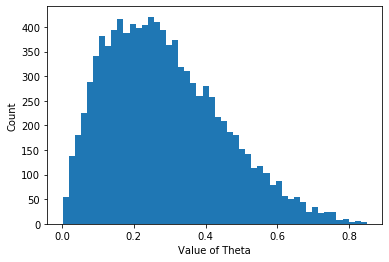

In [4]:
plt.hist(theta,50)
plt.xlabel("Value of Theta")
plt.ylabel("Count")
plt.show()

First 5 heads/tails values (tails=0, heads=1)
	 [0 0 0 0 0 0 1 0 0 0]
Overall frequency of Tails and Heads, accounting for uncertainty about theta itself
	 [0.7115 0.2885]


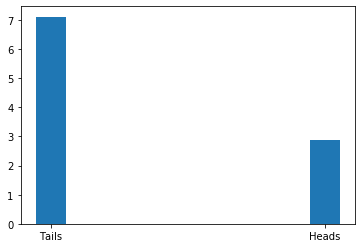

In [5]:
# simulate y from posterior predictive distribution
y = np.random.binomial(1, theta, n_theta) # generate a heads/tails value from each of the 10,000 thetas

print("First 5 heads/tails values (tails=0, heads=1)\n\t", y[0:10])
print("Overall frequency of Tails and Heads, accounting for uncertainty about theta itself\n\t", np.bincount(y)/10000)

plt.hist(y, density=True)
plt.xticks([.05,.95],["Tails","Heads"])
plt.show()

## Beetles

In [6]:
beetles_x = np.array([1.6907, 1.7242, 1.7552, 1.7842, 1.8113, 1.8369, 1.8610, 1.8839])
beetles_x_mean = beetles_x - np.mean(beetles_x)
beetles_n = np.array([59, 60, 62, 56, 63, 59, 62, 60])
beetles_y = np.array([6, 13, 18, 28, 52, 53, 61, 60])
beetles_N = np.array([8]*8)

In [7]:
from scipy.special import expit
expit(2)

0.8807970779778823

In [8]:
with pm.Model() as beetle_model:
    # The intercept (log probability of beetles dying when dose=0)
    # is centered at zero, and wide-ranging (easily anywhere from 0 to 100%)
    # If we wanted, we could choose something like Normal(-3,2) for a no-dose
    # death rate roughly between .007 and .25
    alpha_star = pm.Normal('alpha*', mu=0, sigma=100)
    # the effect on the log-odds of each unit of the dose is wide-ranging:
    # we're saying we've got little idea what the effect will be, and it could
    # be strongly negative.
    beta = pm.Normal('beta', mu=0, sigma=100)
    
    # given alpha, beta, and the dosage, the probability of death is deterministic:
    # it's the inverse logit of the intercept+slope*dosage
    # Because beetles_x has 8 entries, we end up with 8 p_i values
    p_i = pm.Deterministic('$P_i$', pm.math.invlogit(alpha_star + beta*beetles_x_mean))
    
    # finally, the number of bettles we see killed is Binomial(n=number of beetles, p=probability of death)
    deaths = pm.Binomial('obs_deaths', n=beetles_n, p=p_i, observed=beetles_y)
    
    trace = pm.sample(2000, tune=2000, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha*]
Sampling 4 chains, 0 divergences: 100%|█████████████████████████████████████| 16000/16000 [00:08<00:00, 1804.50draws/s]


C:\Program Files\B-Programming\Anaconda3\envs\cs109b\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Program Files\B-Programming\Anaconda3\envs\cs109b\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Program Files\B-Programming\Anaconda3\envs\cs109b\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Program Files\B-Programming\Anaconda3\envs\cs109b\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning

C:\Program Files\B-Programming\Anaconda3\envs\cs109b\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Program Files\B-Programming\Anaconda3\envs\cs109b\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Program Files\B-Programming\Anaconda3\envs\cs109b\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Program Files\B-Programming\Anaconda3\envs\cs109b\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning

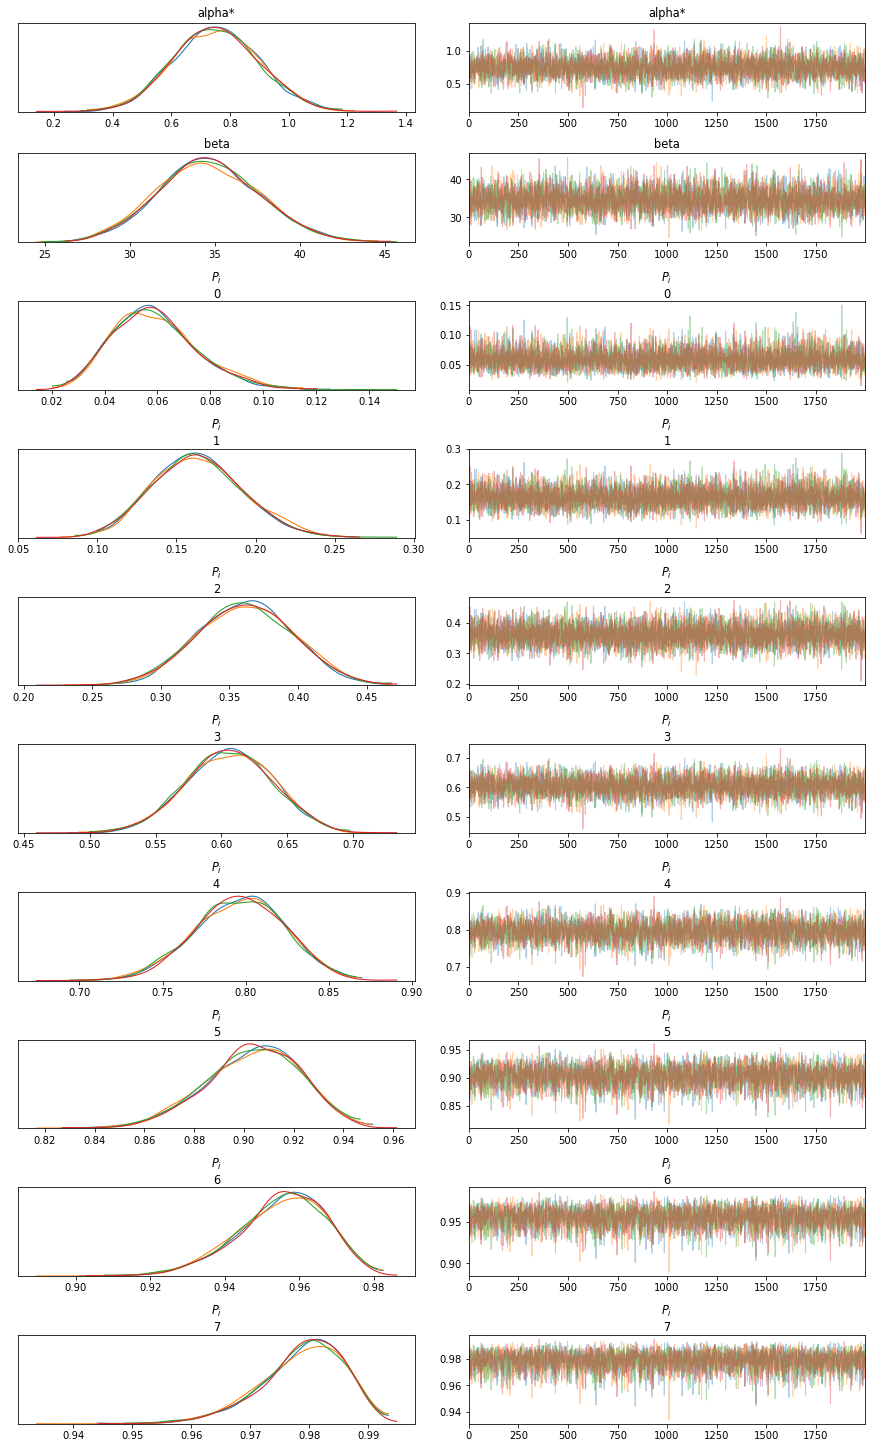

In [9]:
pm.traceplot(trace, compact=False);

In [ ]:
def trace_summary(trace, var_names=None):
    if var_names is None:
        var_names = trace.varnames

    quants = [0.025,0.25,0.5,0.75,0.975]
    colnames = ['mean', 'sd', *["{}%".format(x*100) for x in quants]]
    rownames = []

    series = []
    for cur_var in var_names:
        var_trace = trace[cur_var]
        if var_trace.ndim == 1:
            vals = [np.mean(var_trace, axis=0), np.std(var_trace, axis=0), *np.quantile(var_trace, quants, axis=0)]
            series.append(pd.Series(vals, colnames))
            rownames.append(cur_var)
        else:
            for i in range(var_trace.shape[1]):
                cur_col = var_trace[:,i]
                vals = [np.mean(cur_col, axis=0), np.std(cur_col, axis=0), *np.quantile(cur_col, quants, axis=0)]
                series.append(pd.Series(vals, colnames))
                rownames.append("{}[{}]".format(cur_var,i))

    return pd.DataFrame(series, index=rownames)

trace_summary(trace)

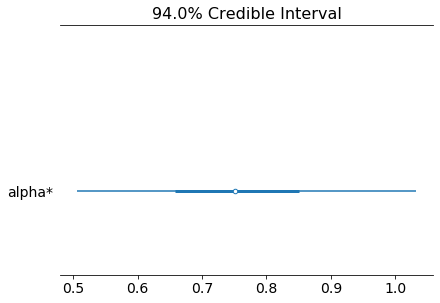

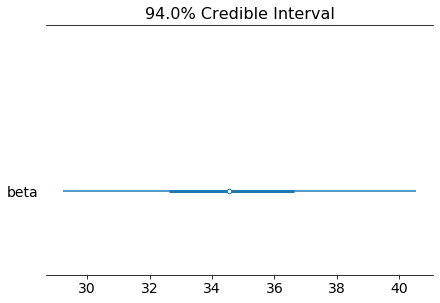

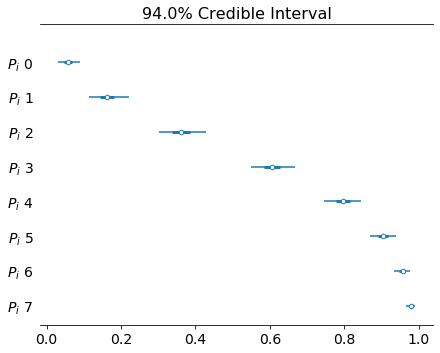

In [11]:
for x in trace.varnames:
    pm.plot_forest(trace, var_names=[x], combined=True)

In addition to the above summaries of the distribution, pymc3 has statistics intended to summarize the quality of the samples. The most common of these is r_hat, which measures whether the different chains seem to be exploring the same space or if they're stuck in different spaces. R-hat above 1.3 is a strong sign the sample isn't good yet. Values close to 1 are ideal.

In [12]:
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha*,0.753,0.140,0.506,1.032,0.002,0.001,5126.0,4992.0,5146.0,4683.0,1.0
beta,34.653,2.992,29.234,40.524,0.042,0.030,5126.0,5096.0,5141.0,5093.0,1.0
$P_i$[0],0.059,0.016,0.031,0.091,0.000,0.000,6538.0,6171.0,6667.0,5495.0,1.0
$P_i$[1],0.164,0.029,0.115,0.221,0.000,0.000,7428.0,7203.0,7461.0,5527.0,1.0
$P_i$[2],0.362,0.035,0.301,0.428,0.000,0.000,7921.0,7877.0,7916.0,5900.0,1.0
$P_i$[3],0.606,0.032,0.549,0.667,0.000,0.000,5841.0,5802.0,5832.0,5102.0,1.0
$P_i$[4],0.797,0.026,0.745,0.844,0.000,0.000,4598.0,4582.0,4565.0,4401.0,1.0
$P_i$[5],0.904,0.019,0.869,0.939,0.000,0.000,4450.0,4448.0,4410.0,4449.0,1.0
$P_i$[6],0.955,0.012,0.933,0.976,0.000,0.000,4468.0,4468.0,4431.0,4263.0,1.0
$P_i$[7],0.979,0.007,0.966,0.991,0.000,0.000,4524.0,4524.0,4489.0,4488.0,1.0


## Sleep Study

In [13]:
import pandas as pd
sleepstudy = pd.read_csv("sleepstudy.csv")

In [14]:
sleepstudy

,Reaction,Days,Subject
0,249.5600,0,308
1,258.7047,1,308
2,250.8006,2,308
3,321.4398,3,308
4,356.8519,4,308
...,...,...,...
175,329.6076,5,372
176,334.4818,6,372
177,343.2199,7,372
178,369.1417,8,372


In [15]:
# adding a column that numbers the subjects from 0 to n
raw_ids = np.unique(sleepstudy['Subject'])
raw2newid = {x:np.where(raw_ids == x)[0][0] for x in raw_ids}

sleepstudy['SeqSubject'] = sleepstudy['Subject'].map(raw2newid)
sleepstudy

,Reaction,Days,Subject,SeqSubject
0,249.5600,0,308,0
1,258.7047,1,308,0
2,250.8006,2,308,0
3,321.4398,3,308,0
4,356.8519,4,308,0
...,...,...,...,...
175,329.6076,5,372,17
176,334.4818,6,372,17
177,343.2199,7,372,17
178,369.1417,8,372,17


In [16]:
with pm.Model() as sleep_model:
    
    # In this model, we're going to say the alphas (individuals' intercepts; their starting reaction time)
    # and betas (individuals' slopes; how much worse they get with lack of sleep) are normally distributed.
    # We'll specify that we're certain about the mean of those distribution [more on that later], but admit
    # we're uncertain about how much spread there is (i.e. uncertain about the SD). Tau_alpha and Tau_beta 
    # will be the respective SD.
    #
    # Of course, the SDs must be positive (negative SD isn't mathematically possible), so we draw them from
    # a Gamma, which cannot ever output negative numbers. Here, we use alpha and beta values that spread the
    # distribution: "the SD could be anything!". If we had more intuition (e.g. "the starting reaction times can't
    # have SD above 3,000") we would plot Gamma(a,b) and tune the parameters so that there was little mass
    # above 3,000, then use those values below)
    tau_alpha = pm.Gamma('tau_alpha', alpha=.001, beta=.001)
    tau_beta = pm.Gamma('tau_beta', alpha=.001, beta=.001)
    
    # Across the population of people, we suppose that
    # the slopes are normally distributed, as are the intercepts,
    # and the two are drawn independently
    #
    # (Here, we hard-code assumed means, but we don't have to.
    # In general, these should be set from our pre-data intuition,
    # rather than from plots/exploration of the data)
    alpha = pm.Normal('alpha', mu=300, tau=tau_alpha, shape=len(raw_ids))
    beta = pm.Normal('beta', mu=10, tau=tau_beta, shape=len(raw_ids))
    
    # Remember: there's only one alpha/beta per person, but
    # we have lots of observations per person. The below
    # builds a vector with one entry per observation, recording
    # the alpha/beta we want to use with that observation.
    #
    # That is, the length is 180, but it only has 17 unique values,
    # matching the 17 unique patients' personal slopes or intercepts
    intercepts = alpha[sleepstudy['SeqSubject']]
    slopes = beta[sleepstudy['SeqSubject']]
    
    # now we have the true/predicted response time for each observation (each row of original data)
    # (Here we use pm.Deterministic to signal that this is something we'll care about)
    mu_i = pm.Deterministic('mu_i', intercepts + slopes*sleepstudy['Days'])
    
    # The _observed_ values are noisy versions of the hidden true values, however! 
    # Specifically, we model them as a normal at the true value and single unknown variance
    # (one explanation: we're saying the measurement equipment adds normally-distributed noise tau_obs
    # so noise doesn't vary from observation to observation or person to person: there's just one universal
    # noise level)
    tau_obs = pm.Gamma('tau_obs', 0.001, 0.001)
    obs = pm.Normal('observed', mu=mu_i, tau=tau_obs, observed=sleepstudy['Reaction'])
    
    trace = pm.sample(2000, tune=2000, target_accept=0.9)

C:\Program Files\B-Programming\Anaconda3\envs\cs109b\lib\site-packages\theano\tensor\subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Program Files\B-Programming\Anaconda3\envs\cs109b\lib\site-packages\theano\tensor\subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_obs, beta, alpha, tau_beta, tau_

In [17]:
# this command can take a few minutes to finish... or never :-/
#pm.traceplot(trace);

In [18]:
trace_summary(trace, var_names=['tau_alpha', 'tau_beta', 'alpha', 'beta', 'tau_obs'])

,mean,sd,2.5%,25.0%,50.0%,75.0%,97.5%
tau_alpha,0.000349,0.000124,0.000155,0.000259,0.000333,0.000421,0.000638
tau_beta,0.032985,0.014427,0.012917,0.022897,0.030339,0.039994,0.068125
alpha[0],257.810550,14.446277,229.498323,248.182334,257.784303,267.490678,285.830563
alpha[1],204.439635,13.955486,176.832478,195.136952,204.208067,213.500740,232.102501
alpha[2],206.372317,14.131066,178.412914,196.909029,206.278937,215.741481,234.567281
alpha[3],284.390485,13.793053,257.437678,275.234788,284.312223,293.331171,311.647627
alpha[4],282.731885,13.349895,257.032663,273.457665,282.593310,291.705621,309.315260
alpha[5],266.119130,13.652895,239.513804,256.788873,266.077897,275.345175,292.776095
alpha[6],275.881615,13.433922,249.499964,266.972681,275.895710,284.821977,302.217257
alpha[7],245.803763,13.722580,219.283539,236.288689,245.789597,255.244031,272.224004


In [19]:
pm.summary(trace, var_names=['tau_alpha', 'tau_beta', 'alpha', 'beta', 'tau_obs'])

C:\Program Files\B-Programming\Anaconda3\envs\cs109b\lib\site-packages\theano\tensor\subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
tau_alpha,0.000,0.000,0.000,0.001,0.000,0.000,12054.0,10352.0,12091.0,6221.0,1.0
tau_beta,0.033,0.014,0.011,0.061,0.000,0.000,7986.0,7122.0,8411.0,6282.0,1.0
alpha[0],257.811,14.447,230.253,284.271,0.135,0.096,11466.0,11396.0,11442.0,6364.0,1.0
alpha[1],204.440,13.956,178.407,230.860,0.131,0.093,11372.0,11263.0,11405.0,6253.0,1.0
alpha[2],206.372,14.132,179.715,233.383,0.128,0.091,12114.0,12050.0,12120.0,5704.0,1.0
alpha[3],284.390,13.794,258.527,310.093,0.125,0.088,12255.0,12184.0,12290.0,6197.0,1.0
alpha[4],282.732,13.351,258.825,308.764,0.128,0.091,10925.0,10876.0,10936.0,5686.0,1.0
alpha[5],266.119,13.654,240.831,291.680,0.123,0.087,12301.0,12242.0,12302.0,6385.0,1.0
alpha[6],275.882,13.435,250.525,301.118,0.128,0.090,11060.0,11060.0,11061.0,6325.0,1.0
alpha[7],245.804,13.723,220.795,271.761,0.127,0.090,11597.0,11543.0,11597.0,5984.0,1.0


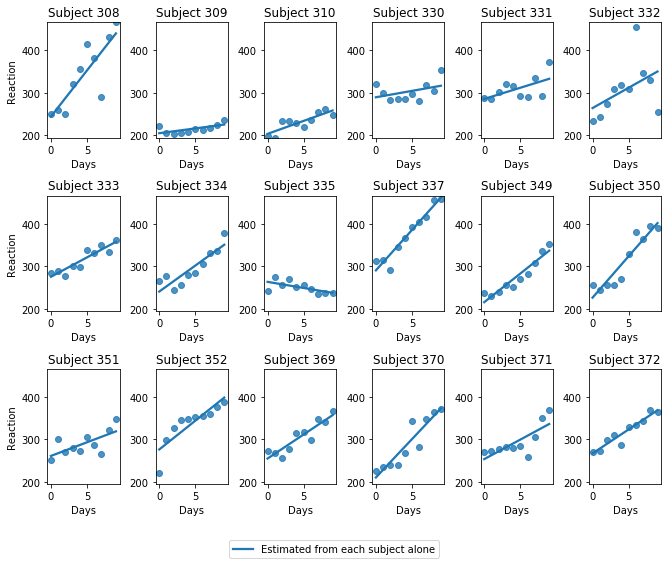

In [20]:
import statsmodels.formula.api as sm
import seaborn as sns
from matplotlib import gridspec


ymin,ymax = np.min(sleepstudy["Reaction"]),np.max(sleepstudy["Reaction"])
plt.figure(figsize=(11,8.5))
gs  = gridspec.GridSpec(3, 6)
gs.update(wspace=0.5, hspace=0.5)
for i, subj in enumerate(np.unique(sleepstudy['Subject'])):
    ss_extract = sleepstudy.loc[sleepstudy['Subject']==subj]
    ss_extract_ols = sm.ols(formula="Reaction~Days",data=ss_extract).fit()
    #new subplot
    subplt = plt.subplot(gs[i])
    #plot without confidence intervals
    sns.regplot(x='Days', y='Reaction', ci=None, data=ss_extract).set_title('Subject '+str(subj))
    if i not in [0,6,12]:
        plt.ylabel("")
    i+=1
    subplt.set_ylim(ymin,ymax)
    
_ = plt.figlegend(['Estimated from each subject alone'],loc = 'lower center', ncol=6)
_ = plt.show()

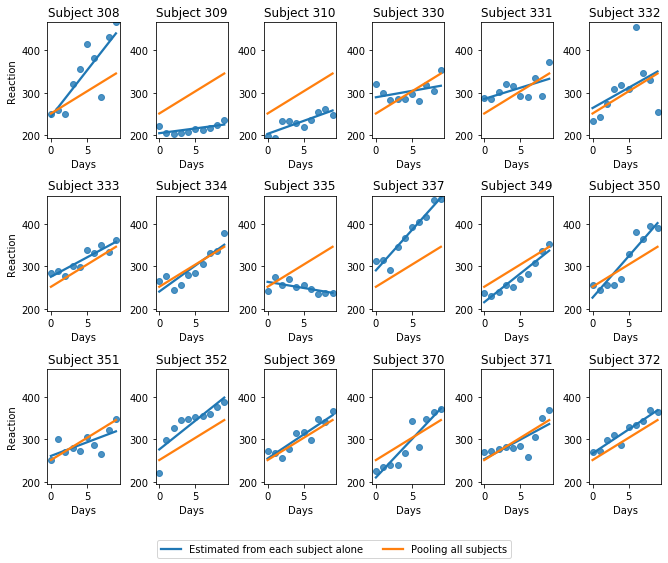

In [21]:
plt.figure(figsize=(11,8.5))
for i, subj in enumerate(np.unique(sleepstudy['Subject'])):
    ss_extract = sleepstudy.loc[sleepstudy['Subject']==subj]
    #new subplot
    subplt = plt.subplot(gs[i])
    #plot without confidence intervals
    sns.regplot(x='Days', y='Reaction', ci=None, data=ss_extract).set_title('Subject '+str(subj)) 
    sns.regplot(x='Days', y='Reaction', ci=None, scatter=False, data=sleepstudy)
    if i not in [0,6,12]:
        plt.ylabel("")
    i+=1
    subplt.set_ylim(ymin,ymax)
    
_ = plt.figlegend(['Estimated from each subject alone','Pooling all subjects'],loc = 'lower center', ncol=6)
_ = plt.show()

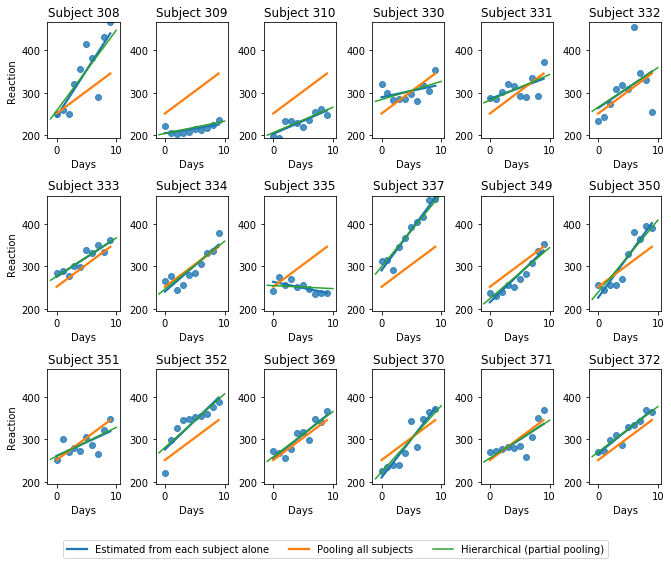

In [22]:
plt.figure(figsize=(11,8.5))
subj_arr = np.unique(sleepstudy['Subject'])
for i, subj in enumerate(subj_arr):
    ss_extract = sleepstudy.loc[sleepstudy['Subject']==subj]
    #new subplot
    subplt = plt.subplot(gs[i])
    
    #plot without confidence intervals
    sns.regplot(x='Days', y='Reaction', ci=None, data=ss_extract).set_title('Subject '+str(subj)) 
    sns.regplot(x='Days', y='Reaction', ci=None, scatter=False, data=sleepstudy)
    
    subj_num = int(np.where(subj_arr==subj)[0])
    
    subjects_avg_intercept = np.mean(trace['alpha'][:,i])
    subjects_avg_slope = np.mean(trace['beta'][:,i])
    hmodel_fit = [subjects_avg_intercept + subjects_avg_slope*x for x in range(-1,11)]
    sns.lineplot(x=range(-1,11),y=hmodel_fit)
    if i not in [0,6,12]:
        plt.ylabel("")
    i+=1
    subplt.set_ylim(ymin,ymax)
    
_ = plt.figlegend(['Estimated from each subject alone','Pooling all subjects','Hierarchical (partial pooling)'],loc = 'lower center', ncol=6)
_ = plt.show()

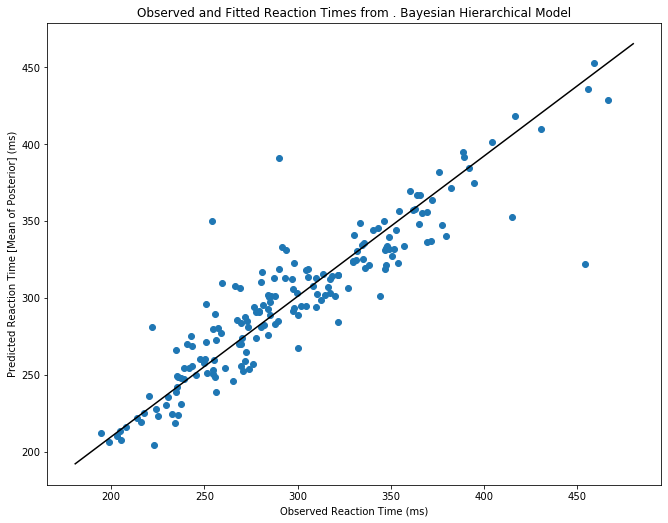

In [23]:
model_predictions = trace['mu_i'].mean(axis=0)
obs_reactions = sleepstudy['Reaction']

plt.figure(figsize=(11,8.5))
plt.scatter(sleepstudy['Reaction'], model_predictions)
plt.plot(plt.xlim(), plt.ylim(), c='black')
plt.xlabel("Observed Reaction Time (ms)")
plt.ylabel("Predicted Reaction Time [Mean of Posterior] (ms)")
plt.title("Observed and Fitted Reaction Times from . Bayesian Hierarchical Model")
plt.show()